In [1]:
### Basic tools
import json
import os
import sys
import time

### Data tools
import numpy as np
import pandas as pd

### Visual tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap as cm

### Preprocessing
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

### Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, precision_score, recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix

### Torch
import torch
from torch import nn, optim
from torch.nn import functional as F

In [2]:
train, test = pd.read_csv('112.csv'), pd.read_csv('113.csv')
print('Shape of train and test: {}/{}'.format(train.shape, test.shape))
print('Any NA in train: {}'.format(train.isna().any().any()))
print('Any NA in train: {}'.format(test.isna().any().any()))
train.head()

Shape of train and test: (6000, 109)/(4000, 108)
Any NA in train: False
Any NA in train: False


,age,body_type,diet,drinks,drugs,education,height,income,last_online,offspring,...,tech,techie,technical,technology,therapist,true,web,websites,wine,writing
0,25,curvy,diet_missing,socially,never,working_on_college_university,63,missing,1,kids_missing,...,0,0,0,0,0,0,0,0,0,0
1,34,fit,mostly_anything,rarely,never,graduated_from_ph_d_program,72,inc50000,2,doesnt_have_kids,...,0,0,0,0,0,0,0,0,0,0
2,32,bodytype_missing,mostly_anything,often,drugs_missing,graduated_from_masters_program,67,missing,1,doesnt_have_kids_but_might_want_them,...,0,0,0,0,0,0,0,0,0,0
3,50,average,mostly_anything,often,never,graduated_from_masters_program,64,missing,24,doesnt_want_kids,...,0,0,0,0,0,1,0,0,1,0
4,23,fit,mostly_anything,socially,sometimes,graduated_from_high_school,70,inc20000,98,kids_missing,...,0,0,0,0,0,0,0,0,0,0


### 1. Class balance

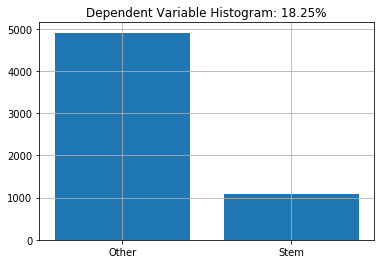

In [3]:
plt.bar(['Other', 'Stem'], train.Class.value_counts())
train.Class = train.Class.map({'other': 0, 'stem': 1}).astype(np.int8)
plt.title('Dependent Variable Histogram: {}%'.format(np.round(train.Class.sum()/train.Class.shape[0]*100, 2)))
plt.grid()
plt.show()

### 2. STRING vars

In [4]:
### Helping string functions

"""
Plot grequency of the categories of a specific variable
"""
def frequencies(df, col_name):
    value_count = sorted(zip(df[col_name].value_counts().values, df[col_name].value_counts().index), reverse=True)
    key, value = [str(i[1]) for i in value_count], [i[0] for i in value_count]
    relative_value = [i for i in np.array(value)/np.sum(value)]
    return key, value, relative_value
 
    
def plot_info(df, col_name, length = 0, vertical = False, figsize=(16, 16), rotation = 90):
    if vertical:
        fig, ax = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax = plt.subplots(2, 1, figsize=figsize)
    # Frequencies
    key, value_fr, value_rlt_fr = frequencies(df, col_name)
    if length != 0:
        other_values = np.sum(value_rlt_fr[length:])
        key, value_rlt_fr = key[:length], value_rlt_fr[:length]
        key.append('others')
        value_rlt_fr.append(other_values)
    ax[0].bar(key, value_rlt_fr)
    ax[0].set_xticklabels(key, rotation=rotation)
    ax[0].set_title('Histogram of {}'.format(col_name))
    ax[0].grid()
    # Distribution
    value_cat = []
    for cat in key:
        tmp = df.loc[df[col_name] == cat, 'Class']
        if cat == 'others':
            tmp = df.loc[df[col_name].isin(key) == False, 'Class']
        value_tmp = tmp.value_counts().values
        if value_tmp.shape[0] == 1:
            value_cat.append(0)
            continue
        percentage = np.round(value_tmp[1]/np.sum(value_tmp)*100, 2)
        value_cat.append(percentage)
    ax[1].bar(key, value_cat)
    ax[1].axhline(y=0.1825*100, color='r', linestyle='-')
    ax[1].grid()
    ax[1].set_xticklabels(key, rotation=rotation)
    ax[1].set_title('Percentage of STEM')
    plt.show()
    
    return key, value_fr, value_cat

def check_missing(df, col_name):
    if [i for i in df[col_name].value_counts().index if 'missing' in i]:
        return True
    return False

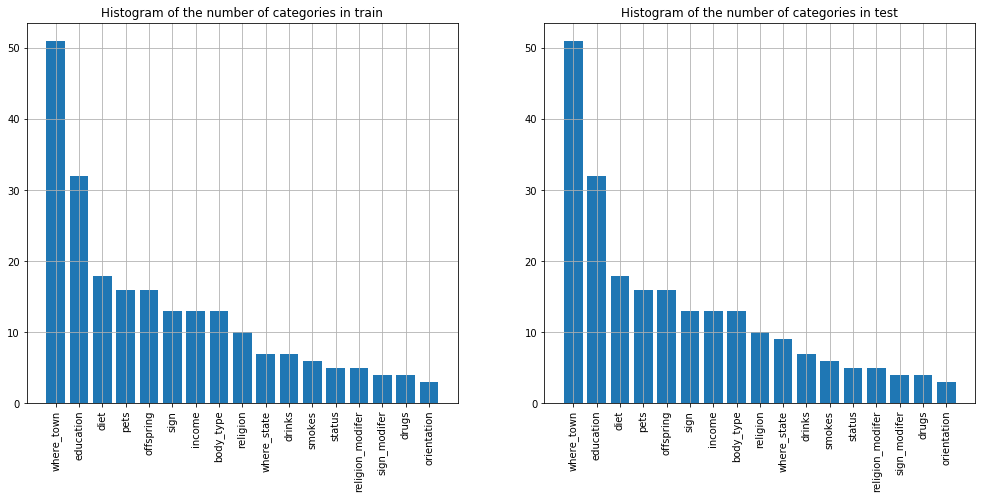

In [5]:
### Analysis of distribution of the number of categories in each variable
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
names = ['train', 'test']
for n, df in enumerate([train, test]):
    string_cols = df.dtypes[df.dtypes == 'object'].index
    feat_number = sorted([(len(df[col_name].value_counts().index), col_name) for col_name in string_cols], reverse=True)
    key, value = [i[1] for i in feat_number], [i[0] for i in feat_number]
    ax[n].bar(key, value)
    ax[n].set_xticklabels(key, rotation=90)
    ax[n].set_title('Histogram of the number of categories in {}'.format(names[n]))
    ax[n].grid()
plt.show()

### 2.a Where Town

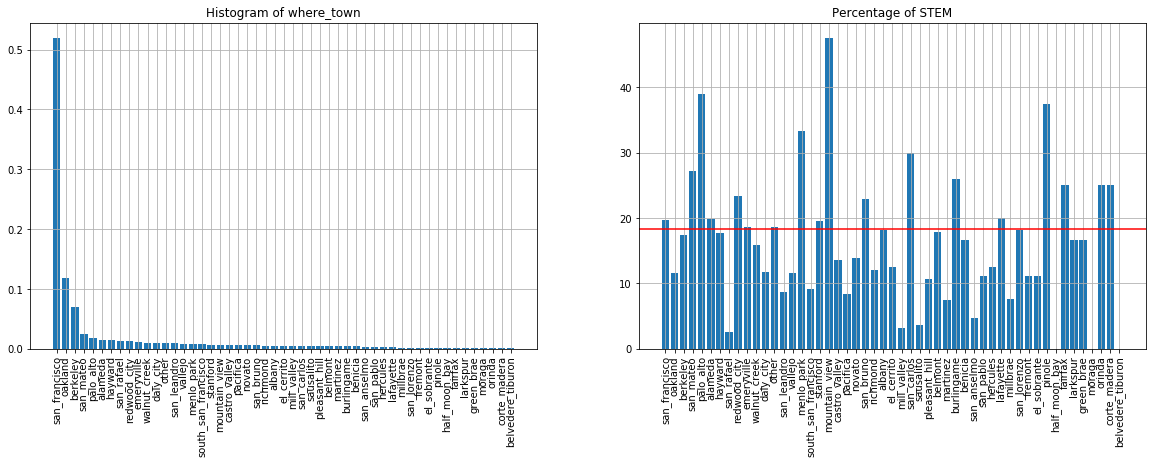

In [6]:
key, fr, cat = plot_info(train, 'where_town', vertical = True , figsize = (20, 6), length=0, rotation=90)

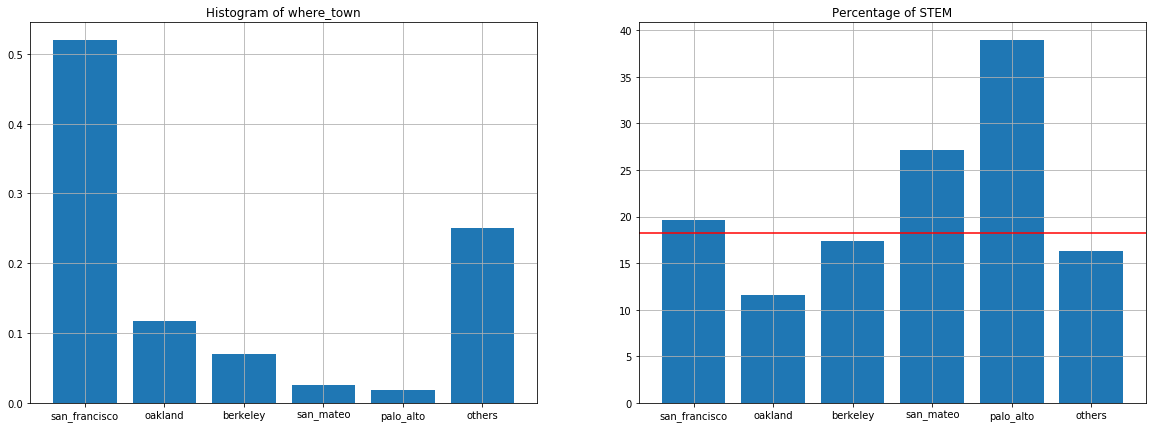

In [7]:
key, fr, cat = plot_info(train, 'where_town', vertical = True , figsize = (20, 7), length=5, rotation=0)
### Changing to 'others' people who live in less frequent cities
train.loc[train.where_town.isin(key[:-1]) == False, 'where_town'] = 'other'

### 2.b Where state

Everyone except 6 people lives in Califorina so this variable is pretty useless and can be eliminated

Any missing value: False


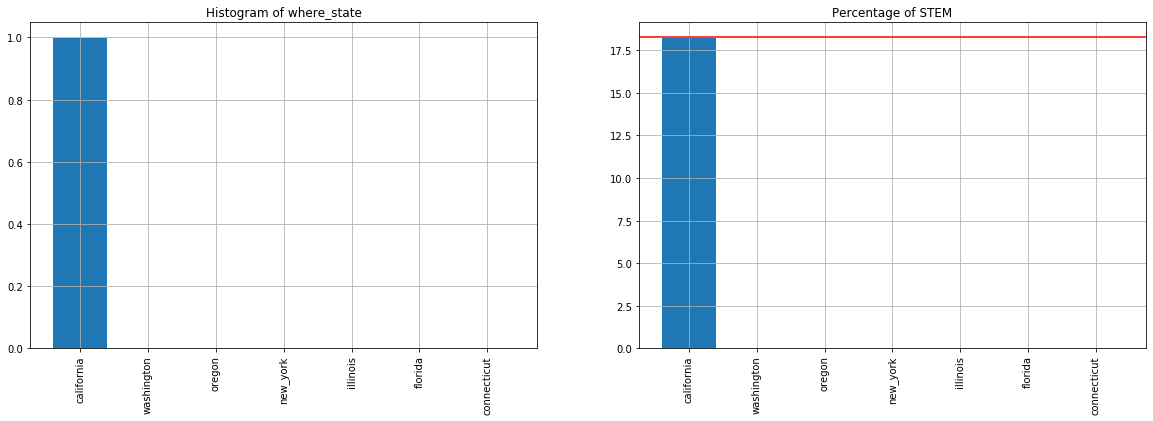

In [8]:
if 'where_state' in train.columns:
    print('Any missing value: {}'.format(check_missing(train, 'where_state')))
    key, fr, cat = plot_info(train, 'where_state', vertical = True , figsize = (20, 6), length=0, rotation=90)
    train.drop(['where_state'], axis=1, inplace=True)

### 2.c Education

Any missing value: True


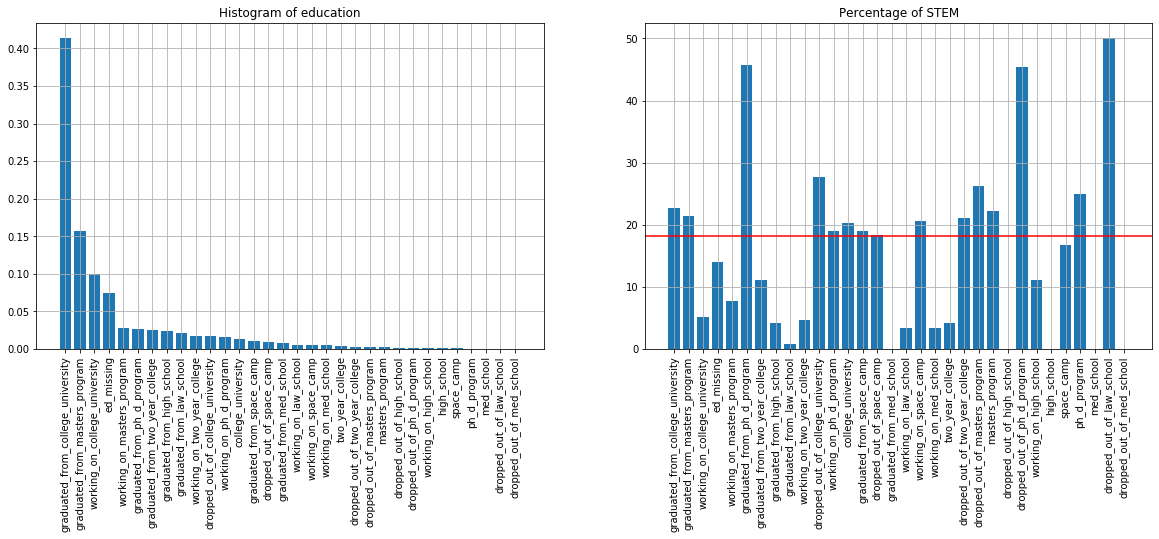

In [9]:
col_name = 'education'

print('Any missing value: {}'.format(check_missing(train, col_name)))
key, fr, cat = plot_info(train, col_name, vertical = True , figsize = (20, 6), length=0, rotation=90)

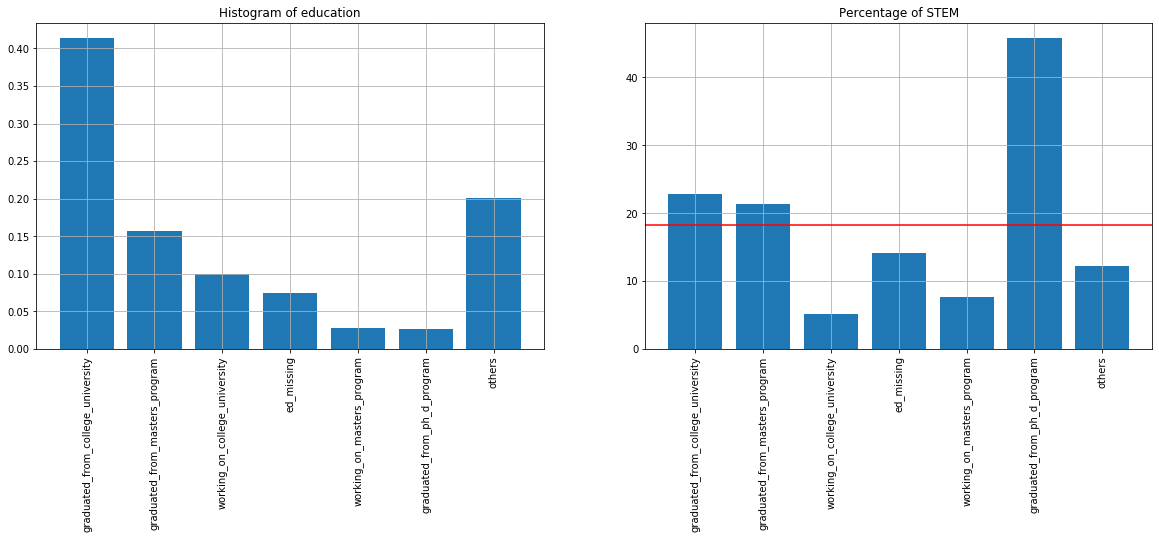

In [10]:
edu_key, fr, cat = plot_info(train, col_name, vertical = True , figsize = (20, 6), length=6, rotation=90)

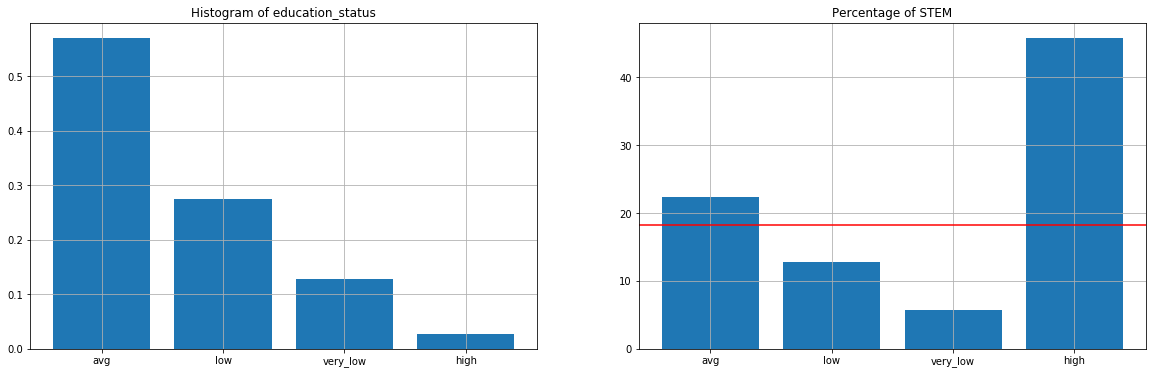

In [11]:
if 'education' in train.columns:
    ### Change education based on proportion of Stem/Non-stem 
    status_keys = edu_key
    values_keys = ['avg', 'avg', 'very_low', 'low', 'very_low', 'high', 'low']
    values_keys2 = [2, 2, 0, 1, 0, 3, 1]
    my_dict = {k: v for k, v in zip(values_keys, values_keys2)}
    train['education_status'] = 0
    for status, value in zip(status_keys[:-1], values_keys[:-1]):
        train.loc[train.education == status, 'education_status'] = value
    train.loc[train.education_status == 0, 'education_status'] = 'low'
    key, fr, cat = plot_info(train, 'education_status', vertical = True , figsize = (20, 6), length=0, rotation=0)
    train.education_status = train.education_status.map(my_dict)

    ### Add NA
    train['education_NA'] = train.education.apply(lambda x: 1 if x == 'ed_missing' else 0)
    
    ### Remove education
    train.drop(['education'], axis=1, inplace=True)
    train[['education_status', 'education_NA']].head()

### 2.d Diet

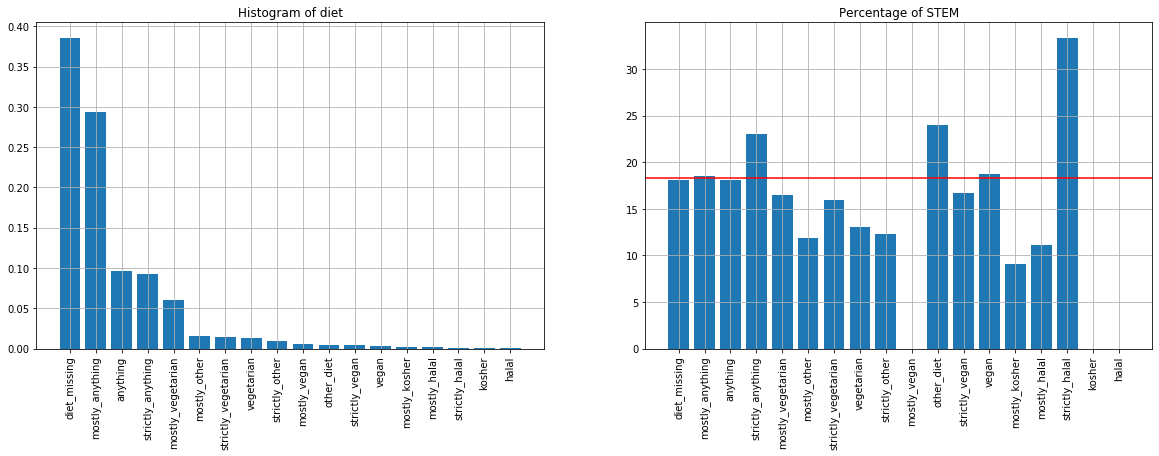

In [12]:
train.loc[train.diet == 'other', 'diet'] = 'other_diet'
key, value, cat = plot_info(train, 'diet', vertical = True , figsize = (20, 6), length=0, rotation=90)

### All mostly vegan users are not STEM so we set avariable for it
train['mostly_vegan'] = 0
train.loc[train.diet == 'mostly_vegan', 'mostly_vegan'] = 1

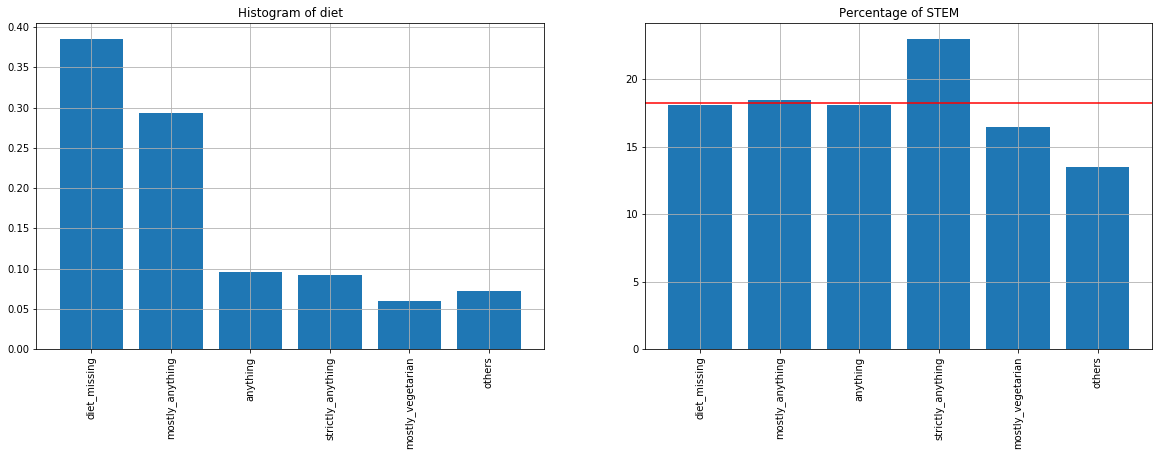

In [13]:
key, value, cat = plot_info(train, 'diet', vertical = True , figsize = (20, 6), length=5, rotation=90)
### Changing to 'others' people who live in less frequent cities
train.loc[train.diet.isin(key[:-1]) == False, 'diet'] = 'other'

In [14]:
diet_types = ['missing', 'anything', 'vegetarian', 'vegan', 'other']
diet_opening = ['missing', 'mostly', 'strictly']
train['diet_type'], train['diet_opening'] = train.diet.copy(), train.diet.copy()

for typ in diet_opening:
    train.diet_opening = train.diet_opening.apply(lambda x: typ if typ in x else x)
for typ in diet_types:
    train.diet_type = train.diet_type.apply(lambda x: typ if typ in x else x)

train['diet_NA'] = train.diet_type.apply(lambda x: 1 if x == 'missing' else 0)
train['diet_other'] = train.diet_type.apply(lambda x: 1 if x == 'other' else 0)
    
train[['diet', 'diet_opening', 'diet_type', 'diet_NA', 'diet_other']].head(10)

,diet,diet_opening,diet_type,diet_NA,diet_other
0,diet_missing,missing,missing,1,0
1,mostly_anything,mostly,anything,0,0
2,mostly_anything,mostly,anything,0,0
3,mostly_anything,mostly,anything,0,0
4,mostly_anything,mostly,anything,0,0
5,strictly_anything,strictly,anything,0,0
6,mostly_anything,mostly,anything,0,0
7,mostly_anything,mostly,anything,0,0
8,mostly_anything,mostly,anything,0,0
9,diet_missing,missing,missing,1,0


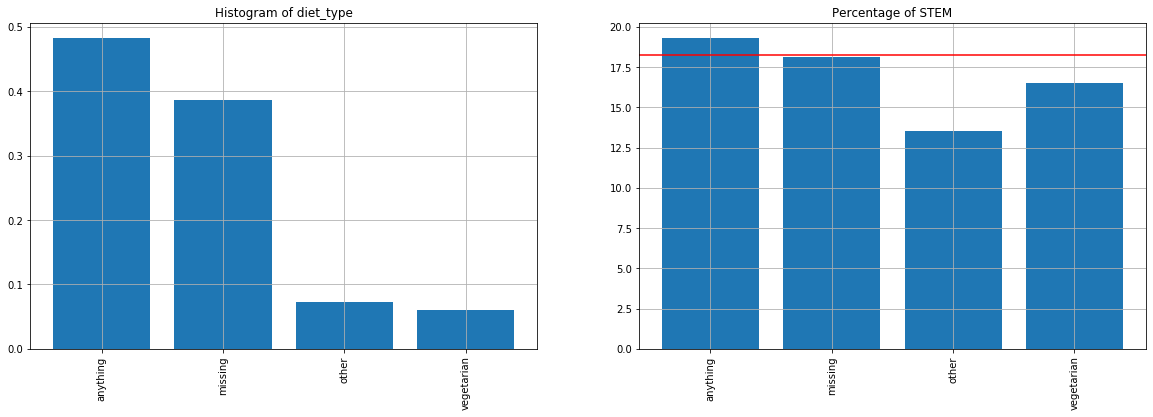

In [15]:
key, value, cat = plot_info(train, 'diet_type', vertical = True , figsize = (20, 6), length=0, rotation=90)
diet_type_dict = {'missing': 0, 'other': 0, 'anything': 0, 'vegetarian': 1}
train.diet_type = train.diet_type.map(diet_type_dict)

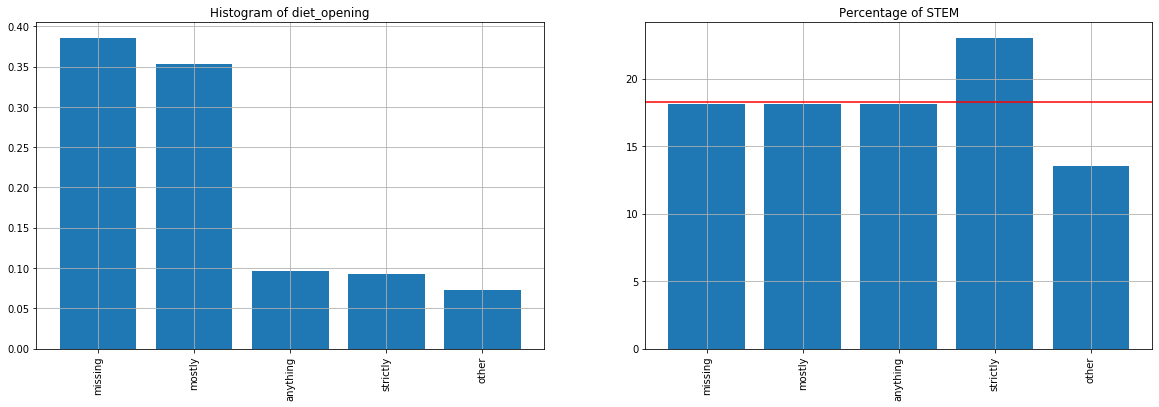

,diet,diet_opening,diet_type,diet_NA,diet_other,mostly_vegan
0,diet_missing,0,0,1,0,0
1,mostly_anything,1,0,0,0,0
2,mostly_anything,1,0,0,0,0
3,mostly_anything,1,0,0,0,0
4,mostly_anything,1,0,0,0,0
5,strictly_anything,2,0,0,0,0
6,mostly_anything,1,0,0,0,0
7,mostly_anything,1,0,0,0,0
8,mostly_anything,1,0,0,0,0
9,diet_missing,0,0,1,0,0


In [16]:
key, value, cat = plot_info(train, 'diet_opening', vertical = True , figsize = (20, 6), length=0, rotation=90)
diet_opening_dict = {'missing': 0, 'other': 0, 'anything': 0, 'mostly': 1, 'strictly': 2}
train.diet_opening = train.diet_opening.map(diet_opening_dict)
train[['diet', 'diet_opening', 'diet_type', 'diet_NA', 'diet_other', 'mostly_vegan']].head(20)

In [17]:
if 'diet' in train.columns:
    train.drop(['diet'], axis=1, inplace=True)

### 2.e Pets

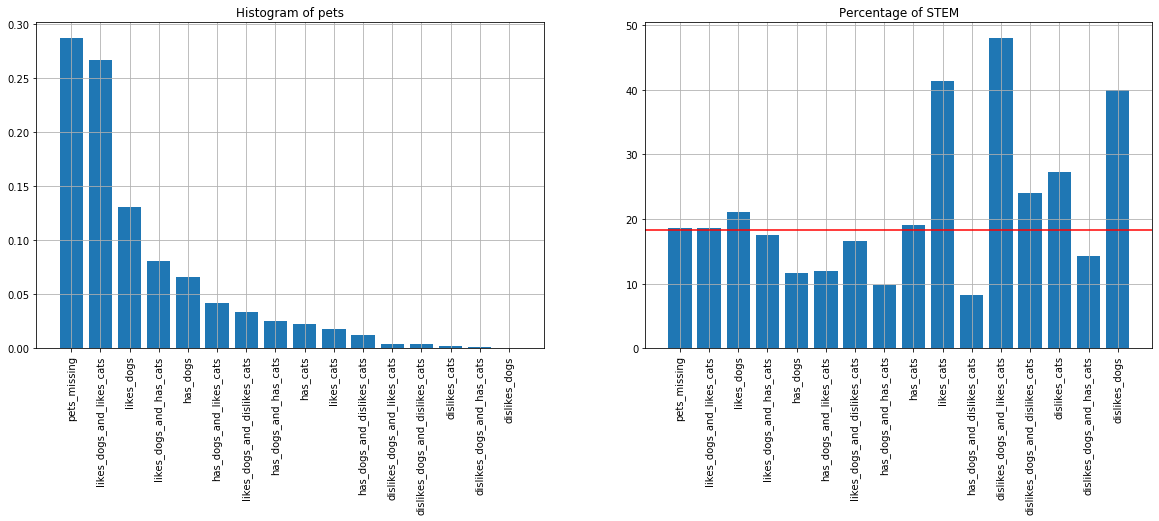

In [18]:
key, value, cat = plot_info(train, 'pets', vertical = True , figsize = (20, 6), length=0, rotation=90)

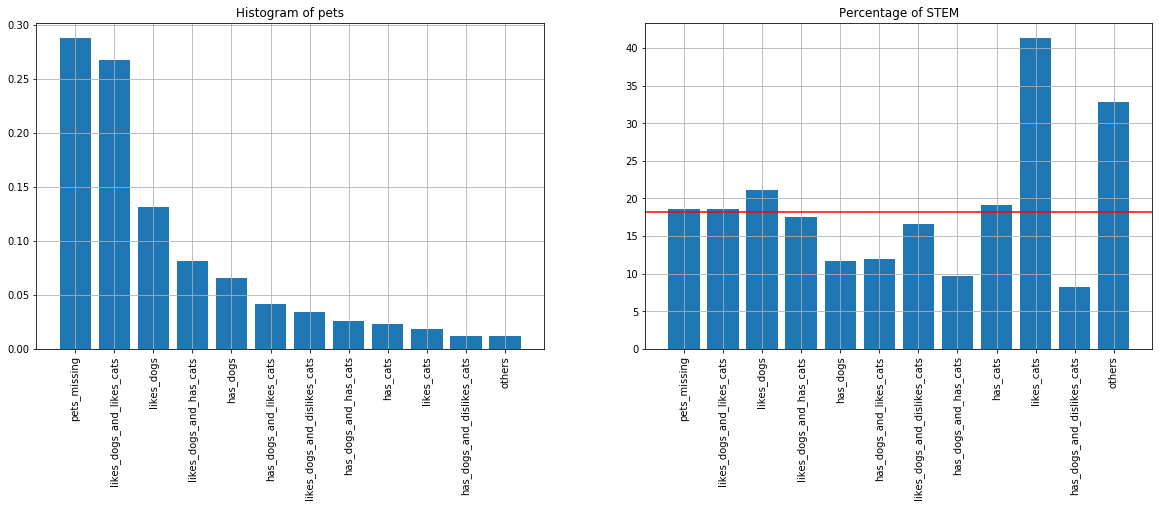

In [19]:
key, value, cat = plot_info(train, 'pets', vertical = True , figsize = (20, 6), length=11, rotation=90)

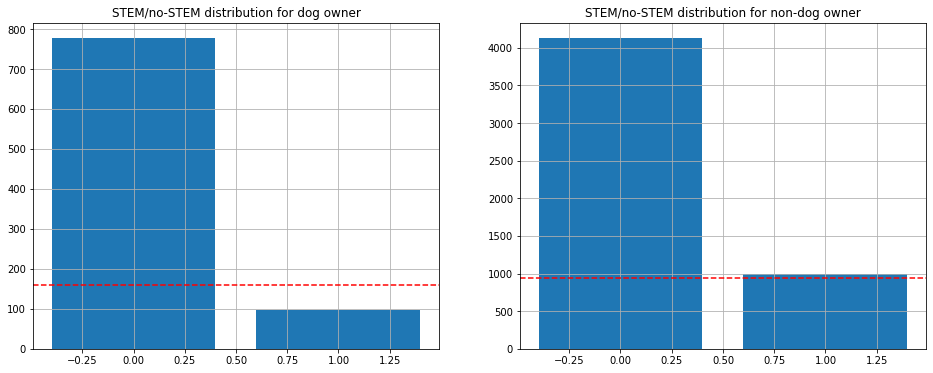

,pets,has_dogs,other_pet,like_cats,pets_NA
0,pets_missing,0,0,0,1
1,likes_dogs,0,0,0,0
2,pets_missing,0,0,0,1
3,likes_dogs_and_likes_cats,0,0,0,0
4,likes_dogs_and_likes_cats,0,0,0,0


In [20]:
train['has_dogs'] = series = train.pets.apply(lambda x: 1 if 'has_dogs' in x else 0)
train['other_pet'] = train.pets.apply(lambda x: 0 if x in key[:-1] else 1)
train['like_cats'] = train.pets.apply(lambda x: 1 if x == 'likes_cats' else 0)
train['pets_NA'] = train.pets.apply(lambda x: 1 if x == 'pets_missing' else 0)

series1 = train.loc[series == 1, 'Class']
series2 = train.loc[series == 0, 'Class']


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].bar(series1.value_counts().index, series1.value_counts().values)
ax[0].grid()
ax[0].set_title('STEM/no-STEM distribution for dog owner')
ax[0].axhline(y=0.1825*series1.shape[0], color='r', linestyle='--')
ax[1].bar(series2.value_counts().index, series2.value_counts().values)
ax[1].grid()
ax[1].axhline(y=0.1825*series2.shape[0], color='r', linestyle='--')
ax[1].set_title('STEM/no-STEM distribution for non-dog owner')
plt.show()

train[['pets', 'has_dogs', 'other_pet', 'like_cats', 'pets_NA']].head()

In [21]:
train.drop(['pets'], axis=1, inplace=True)

### 2.f Sign

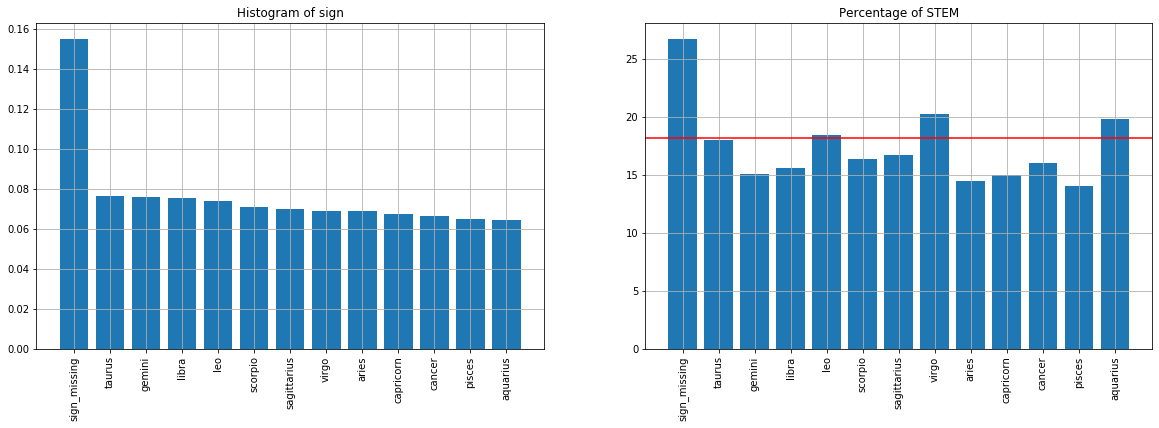

In [22]:
key, value, cat = plot_info(train, 'sign', vertical = True , figsize = (20, 6), length=0, rotation=90)

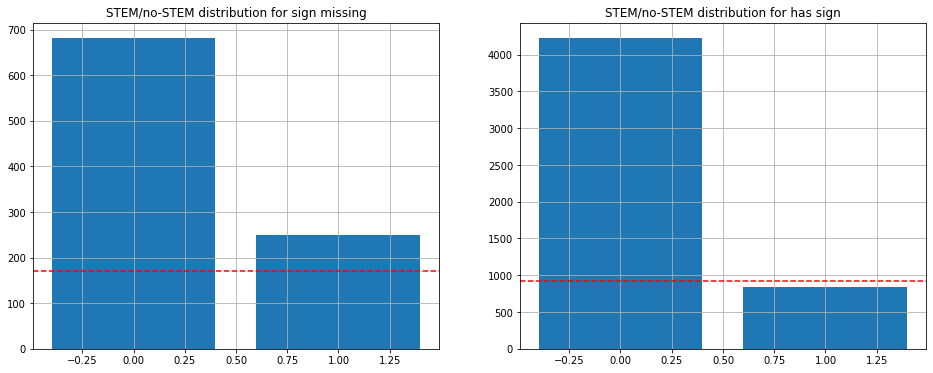

In [23]:
train['no_sig'] = series = train.sign.apply(lambda x: 1 if x == 'sign_missing' else 0)
series1 = train.loc[series == 1, 'Class']
series2 = train.loc[series == 0, 'Class']


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].bar(series1.value_counts().index, series1.value_counts().values)
ax[0].grid()
ax[0].set_title('STEM/no-STEM distribution for sign missing')
ax[0].axhline(y=0.1825*series1.shape[0], color='r', linestyle='--')
ax[1].bar(series2.value_counts().index, series2.value_counts().values)
ax[1].grid()
ax[1].axhline(y=0.1825*series2.shape[0], color='r', linestyle='--')
ax[1].set_title('STEM/no-STEM distribution for has sign')
plt.show()

In [24]:
train.drop(['sign'], axis=1, inplace=True)

### 2.g Offspring

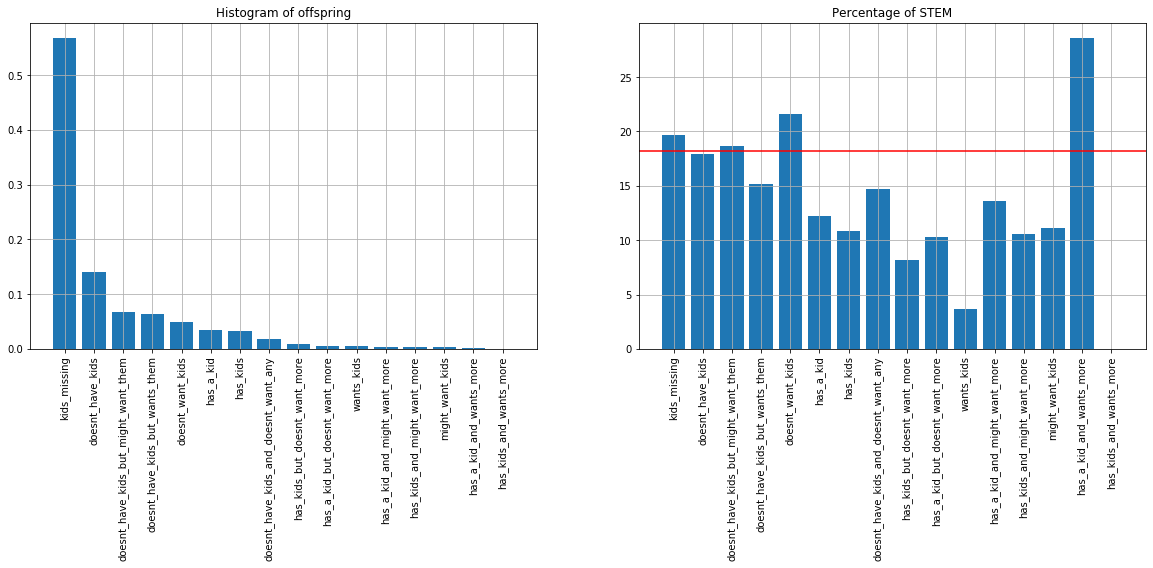

In [25]:
key, value, cat = plot_info(train, 'offspring', vertical = True , figsize = (20, 6), length=0, rotation=90)

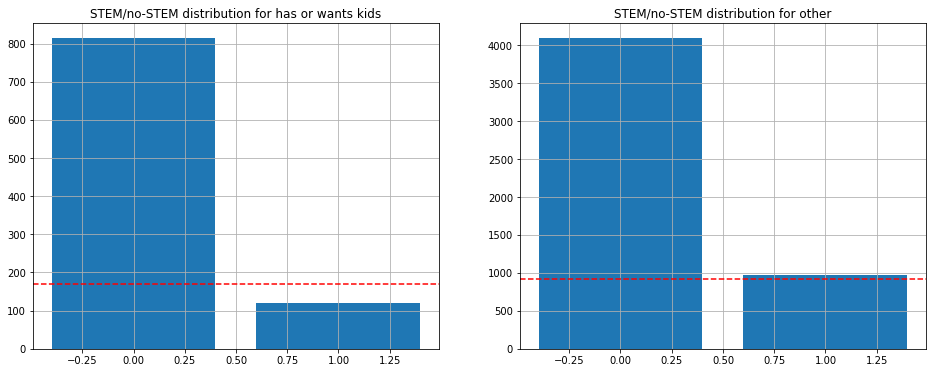

,offspring,has_wants_kid,kids_NA
0,kids_missing,0,1
1,doesnt_have_kids,0,0
2,doesnt_have_kids_but_might_want_them,0,0
3,doesnt_want_kids,0,0
4,kids_missing,0,1


In [26]:
train['has_wants_kid'] = series = train.offspring.apply(lambda x: 1 if ('has' in x) or ('wants') in x else 0)
train['kids_NA'] = train.offspring.apply(lambda x: 1 if x == 'kids_missing' else 0)
series1 = train.loc[series == 1, 'Class']
series2 = train.loc[series == 0, 'Class']


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].bar(series1.value_counts().index, series1.value_counts().values)
ax[0].grid()
ax[0].set_title('STEM/no-STEM distribution for has or wants kids')
ax[0].axhline(y=0.1825*series1.shape[0], color='r', linestyle='--')
ax[1].bar(series2.value_counts().index, series2.value_counts().values)
ax[1].grid()
ax[1].axhline(y=0.1825*series2.shape[0], color='r', linestyle='--')
ax[1].set_title('STEM/no-STEM distribution for other')
plt.show()

train[['offspring', 'has_wants_kid', 'kids_NA']].head()

In [27]:
train.drop(['offspring'], axis=1, inplace=True)

### 2.h Income

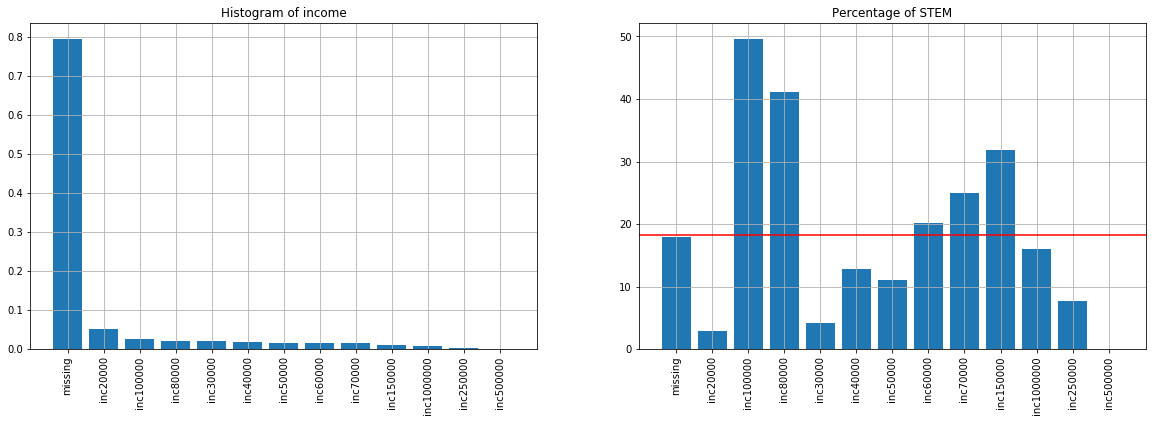

In [28]:
key, value, cat = plot_info(train, 'income', vertical = True , figsize = (20, 6), length=0, rotation=90)

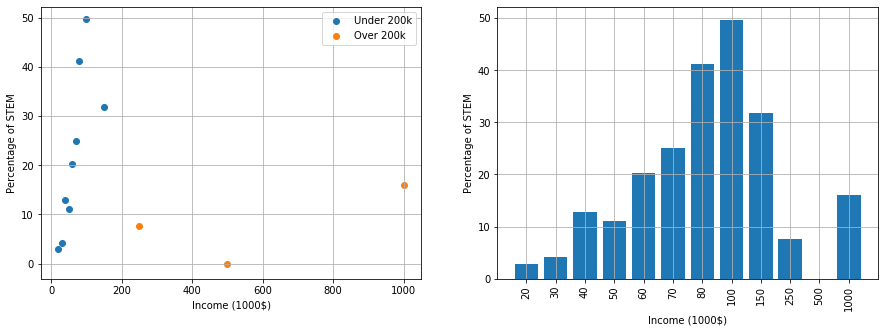

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
zipped = sorted([(m, n) for m, n in zip([int(i[3:])//1000 for i in key[1:]], cat[1:])])
ax[0].scatter([i[0] for i in zipped[:-3]], [i[1] for i in zipped][:-3], label='Under 200k')
ax[0].scatter([i[0] for i in zipped[-3:]], [i[1] for i in zipped][-3:], label='Over 200k')
ax[0].legend()
ax[0].set_xlabel('Income (1000$)')
ax[0].set_ylabel('Percentage of STEM')
ax[0].grid()

plt.bar([str(i[0]) for i in zipped], [i[1] for i in zipped])
ax[1].set_xticklabels([str(i[0]) for i in zipped], rotation=90)
ax[1].set_xlabel('Income (1000$)')
ax[1].set_ylabel('Percentage of STEM')
ax[1].grid()
plt.show()

In [30]:
def f(x):
    if x == 0:
        return 0
    elif x > 0 and x <= 30*1000:
        return 1
    elif x > 30*1000 and x <= 50*1000:
        return 2
    elif x > 50*1000 and x <= 70*1000:
        return 3
    elif x == 150*1000:
        return 4
    elif x > 150*1000:
        return 2
    else:
        return 5
    
train['income'] = train.income.apply(lambda x: int(x[3:]) if 'inc' in x else 0)
train['income_NA'] = train.income.apply(lambda x: 1 if x == 0 else 0)
train['income_cat'] = train.income.apply(lambda x: f(x))
train[['income', 'income_cat', 'income_NA']].head()

,income,income_cat,income_NA
0,0,0,1
1,50000,2,0
2,0,0,1
3,0,0,1
4,20000,1,0


### 2.i Body Type

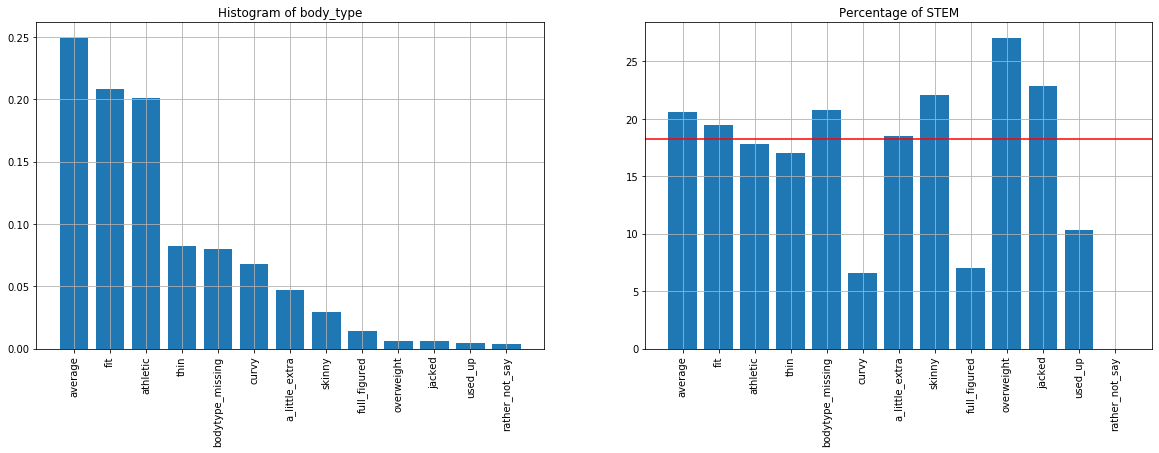

In [31]:
key, value, cat = plot_info(train, 'body_type', vertical = True , figsize = (20, 6), length=0, rotation=90)

In [32]:
key1, key2 = np.array(key)[[0, 1, 2, 3, 4, 6, 7, 9, 10]], np.array(key)[[5, 8, 11, 12]]
train['body_NA'] = train.body_type.apply(lambda x: 1 if 'missing' in x else 0)
train.body_type = train.body_type.apply(lambda x: 1 if x in key1 else 0)
train[['body_type', 'body_NA']].head()

,body_type,body_NA
0,0,0
1,1,0
2,1,1
3,1,0
4,1,0


### 2.j Religion

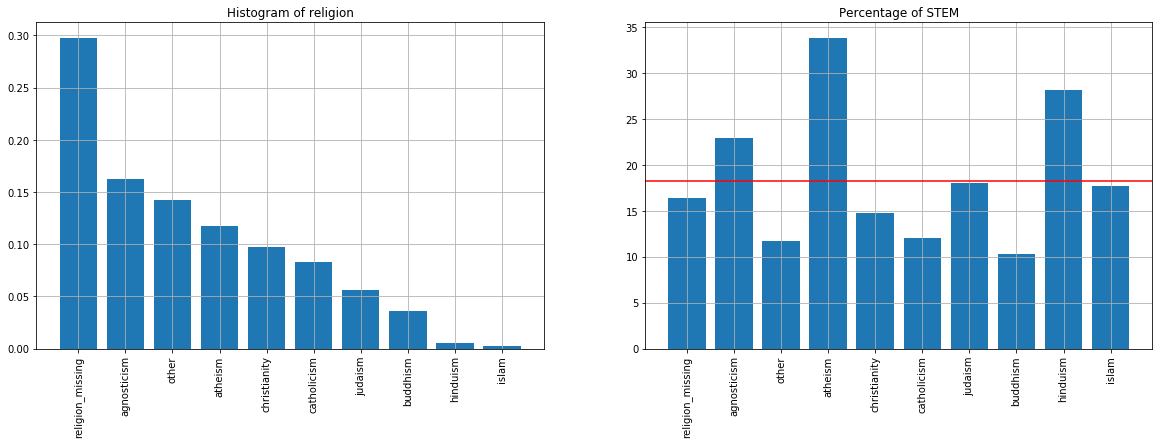

In [33]:
key, value, cat = plot_info(train, 'religion', vertical = True , figsize = (20, 6), length=0, rotation=90)

In [34]:
train['religion_NA'] = train.religion.apply(lambda x: 1 if 'missing' in x else 0)
my_religion_dict = {'atheism': 3, 'hinduism': 3, 
                    'agnosticism': 2,
                    'religion_missing': 1, 'islam': 1, 'judaism': 1,
                    'other': 0, 'christianity': 0, 'catholicism': 0, 'buddhism': 0}
train.religion = train.religion.map(my_religion_dict)

### 2.k Drinks

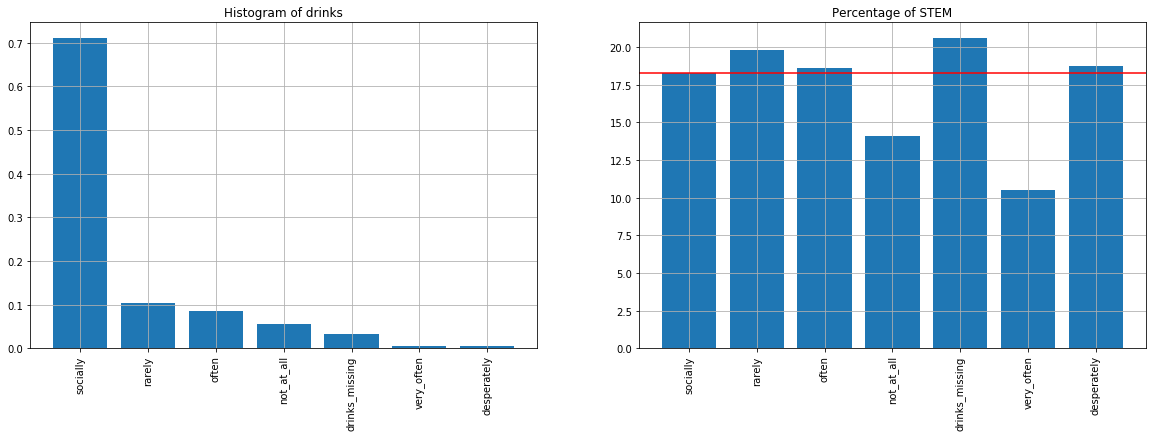

In [35]:
key, value, cat = plot_info(train, 'drinks', vertical = True , figsize = (20, 6), length=0, rotation=90)

### 2.l Smokes

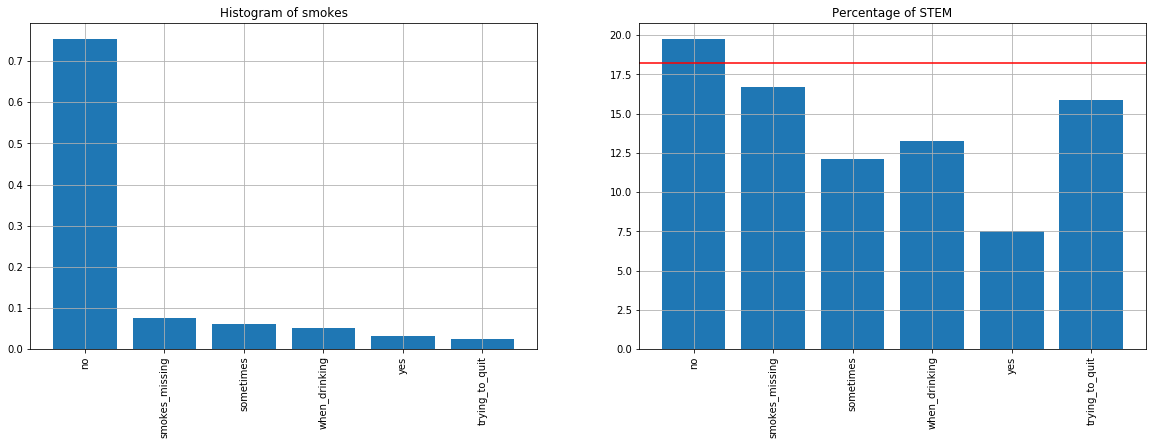

In [36]:
key, value, cat = plot_info(train, 'smokes', vertical = True , figsize = (20, 6), length=0, rotation=90)

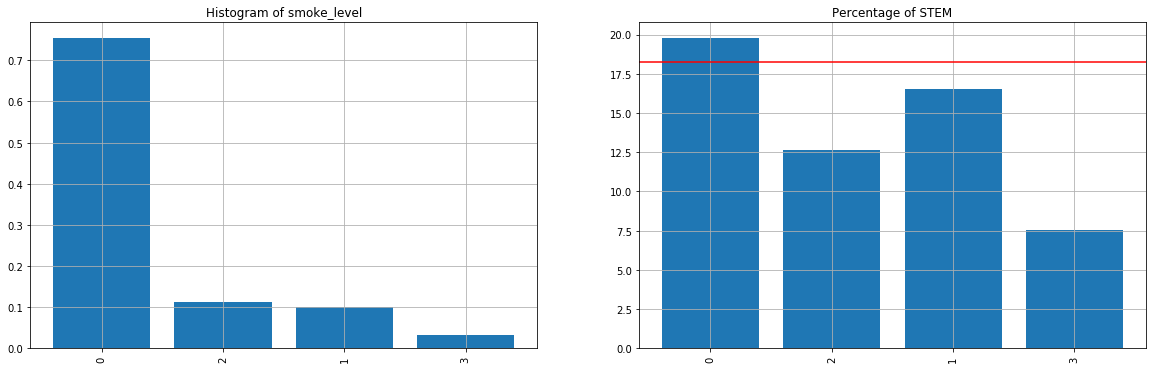

In [37]:
train['smoke_NA'] = train.smokes.apply(lambda x: 1 if 'missing' in x else 0)
my_smoke_dict = {'no': '0', 'sometimes': '2', 'when_drinking': '2', 'yes': '3', 'trying_to_quit': '1', 'smokes_missing': '1'}
train['smoke_level'] = train.smokes.map(my_smoke_dict)
key, value, cat = plot_info(train, 'smoke_level', vertical = True , figsize = (20, 6), length=0, rotation=90)

In [38]:
train.smoke_level = train.smoke_level.astype(np.int16)
train.drop(['smokes'], axis=1, inplace=True)

### 2.m Status

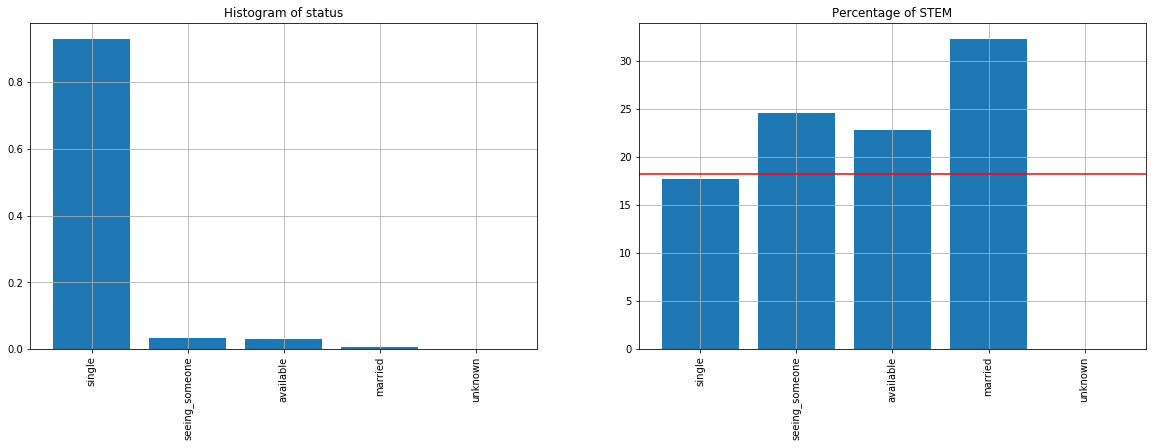

In [39]:
key, value, cat = plot_info(train, 'status', vertical = True , figsize = (20, 6), length=0, rotation=90)

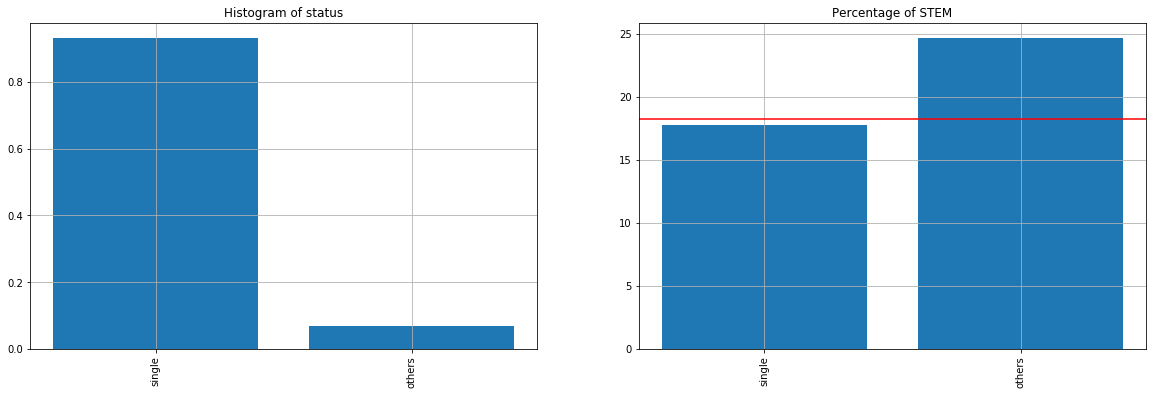

In [40]:
key, value, cat = plot_info(train, 'status', vertical = True , figsize = (20, 6), length=1, rotation=90)
train.status = train.status.apply(lambda x: 1 if x == 'single' else 0)

### 2.n Religion Modifer

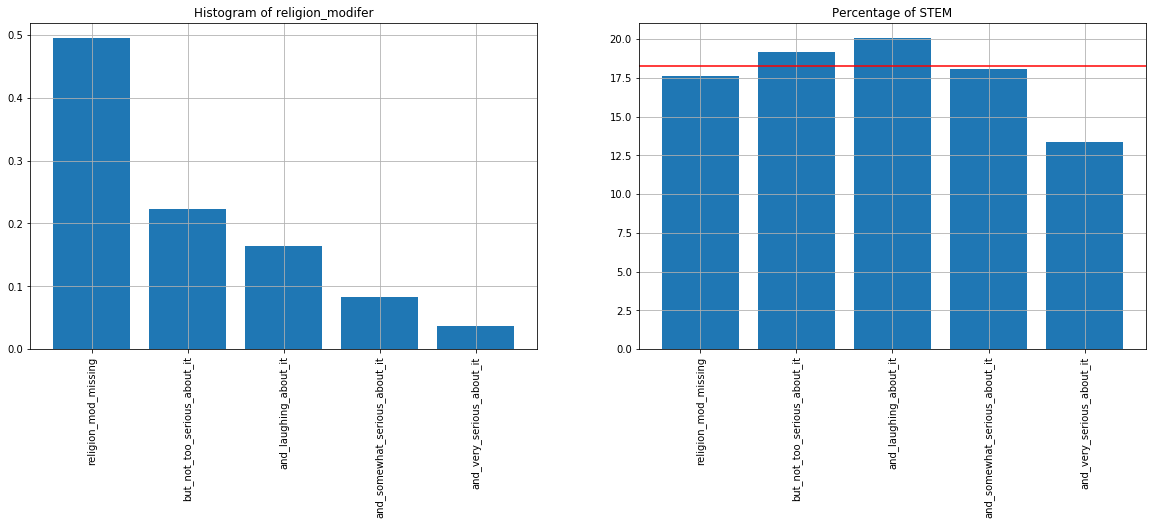

In [41]:
key, value, cat = plot_info(train, 'religion_modifer', vertical = True , figsize = (20, 6), length=0, rotation=90)
### Dropped for now
train['religion_NA'] = train.religion_modifer.apply(lambda x: 1 if 'missing' in x else 0)
train.drop(['religion_modifer'], axis = 1, inplace = True)

### 2.o Sign Modifer

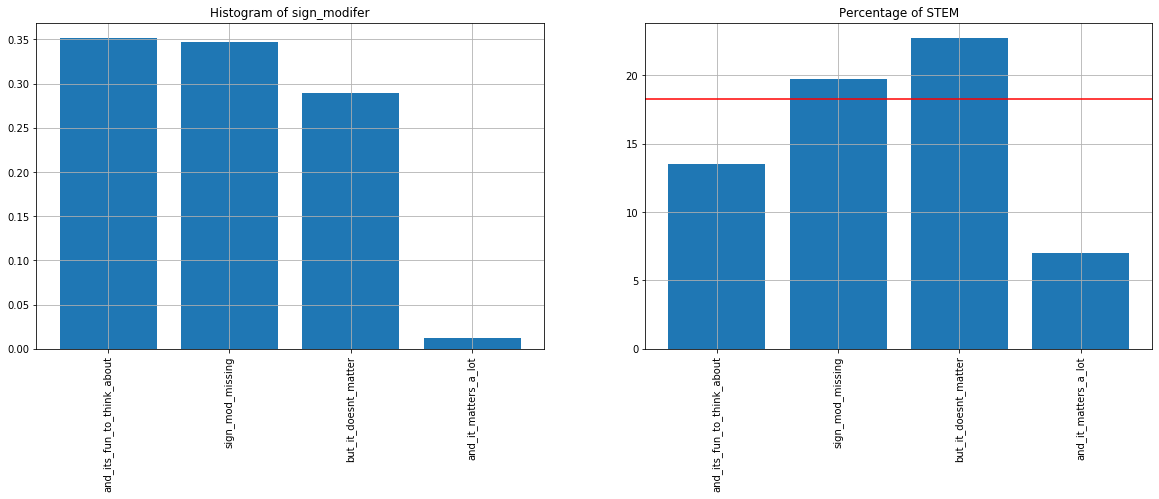

In [42]:
key, value, cat = plot_info(train, 'sign_modifer', vertical = True , figsize = (20, 6), length=0, rotation=90)

train['sign_mod_NA'] = train.sign_modifer.apply(lambda x: 1 if 'missing' in x else 0)

my_sign_mod_dict = {'and_it_matters_a_lot': 0, 'and_its_fun_to_think_about': 0, 
                    'but_it_doesnt_matter': 1, 'sign_mod_missing': 1}
train.sign_modifer = train.sign_modifer.map(my_sign_mod_dict)

### 2.p Drugs

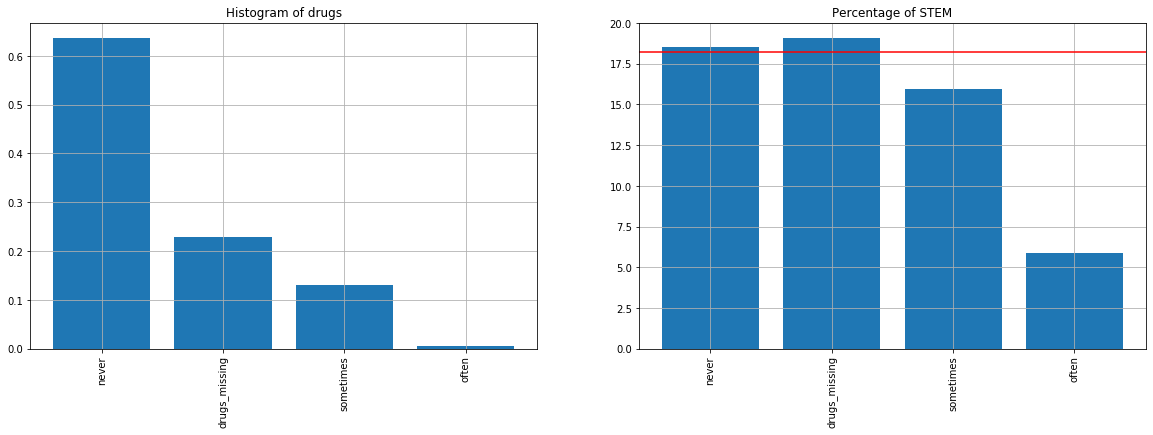

In [43]:
key, value, cat = plot_info(train, 'drugs', vertical = True , figsize = (20, 6), length=0, rotation=90)

### 2.q Orientation

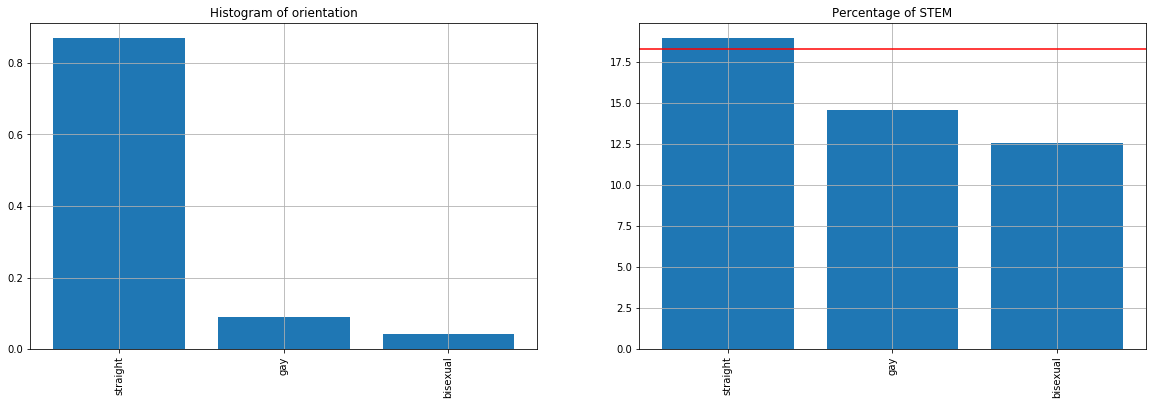

In [44]:
key, value, cat = plot_info(train, 'orientation', vertical = True , figsize = (20, 6), length=0, rotation=90)

### 3.a Age

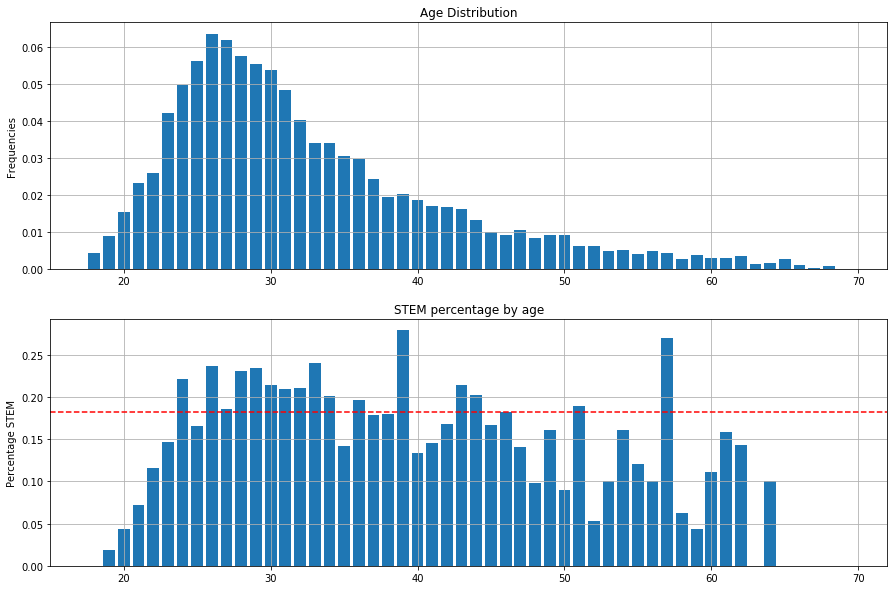

In [45]:
### Remove outlier
if train[train.age > 80].shape[0] > 0:
    train.drop(train[train.age > 80].index, axis=0, inplace=True)

ages = sorted(train.age.value_counts().index)
stem_by_age = [train.loc[train.age == age, 'Class'].sum()/train.loc[train.age == age, 'Class'].shape[0] for age in ages]
freq_by_age = [train.loc[train.age == age].shape[0]/train.shape[0] for age in ages]

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].bar(ages, freq_by_age)
ax[0].grid()
ax[0].set_title('Age Distribution')
ax[0].set_ylabel('Frequencies')

ax[1].bar(ages, stem_by_age)
ax[1].set_title('STEM percentage by age')
ax[1].set_ylabel('Percentage STEM')
ax[1].axhline(y=0.1825, color='r', linestyle='--')
ax[1].grid()
plt.show()

### 3.b Height

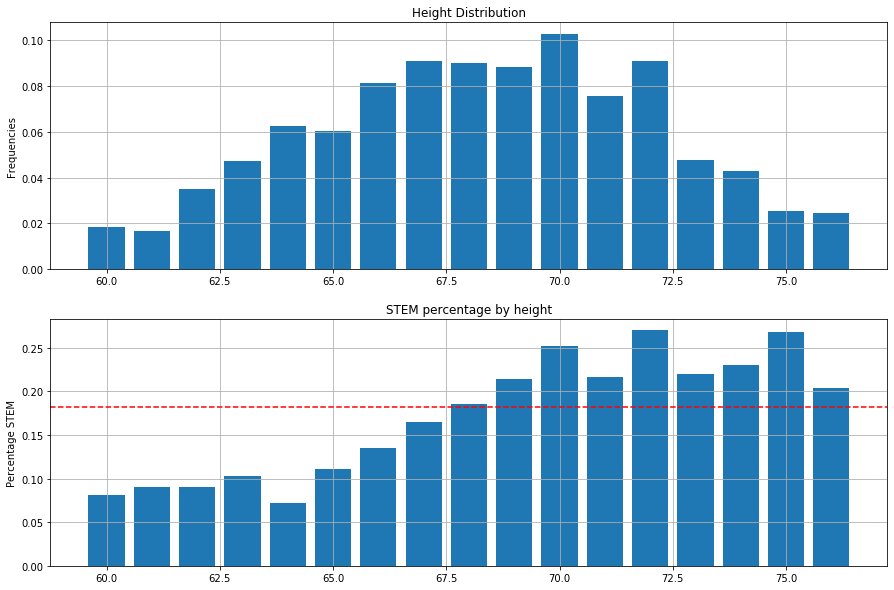

In [46]:
train.loc[train.height > 76, 'height'] = 76
train.loc[train.height < 60, 'height'] = 60

heights = sorted(train.height.value_counts().index)
stem_by_height = [train.loc[train.height == height, 'Class'].sum()/train.loc[train.height == height, 'Class'].shape[0] for height in heights]
freq_by_height = [train.loc[train.height == height].shape[0]/train.shape[0] for height in heights]

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].bar(heights, freq_by_height)
ax[0].grid()
ax[0].set_title('Height Distribution')
ax[0].set_ylabel('Frequencies')

ax[1].bar(heights, stem_by_height)
ax[1].set_title('STEM percentage by height')
ax[1].set_ylabel('Percentage STEM')
ax[1].axhline(y=0.1825, color='r', linestyle='--')
ax[1].grid()
plt.show()

In [59]:
def f_height(x):
    if x <= 65:
        return 0
    elif x <= 68:
        return 1
    else:
        return 2

train['height_cat'] = train.height.apply(f_height)
train[['height', 'height_cat']].head()

,height,height_cat
0,63,0
1,72,2
2,67,1
3,64,0
4,70,2


## 4. Missing INFO

In [56]:
missing_col = [i for i in train.columns if '_NA' in i]
tmp = train[missing_col].copy()
tmp['total'] = tmp.sum(axis=1)
tmp['Class'] = train.Class
tmp.head()

,education_NA,diet_NA,pets_NA,kids_NA,income_NA,body_NA,religion_NA,smoke_NA,sign_mod_NA,total,Class
0,0,1,1,1,1,0,0,0,0,4,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,1,1,0,5,0
3,0,0,0,0,1,0,1,0,1,3,0
4,0,0,0,1,0,0,0,0,0,1,0


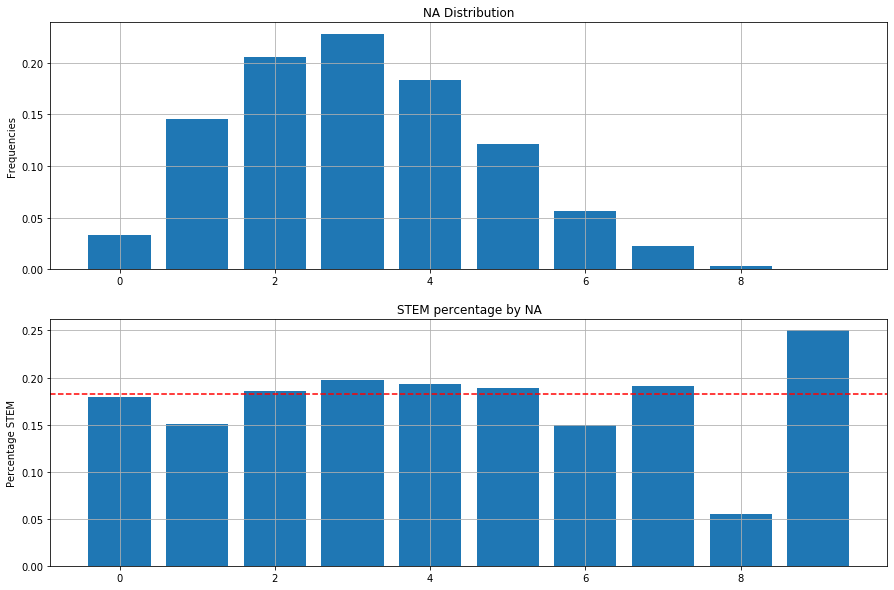

In [58]:
tots = sorted(tmp.total.value_counts().index)
stem_by_tot = [tmp.loc[tmp.total == tot, 'Class'].sum()/tmp.loc[tmp.total == tot, 'Class'].shape[0] for tot in tots]
freq_by_tot = [tmp.loc[tmp.total == tot].shape[0]/tmp.shape[0] for tot in tots]

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].bar(tots, freq_by_tot)
ax[0].grid()
ax[0].set_title('NA Distribution')
ax[0].set_ylabel('Frequencies')

ax[1].bar(tots, stem_by_tot)
ax[1].set_title('STEM percentage by NA')
ax[1].set_ylabel('Percentage STEM')
ax[1].axhline(y=0.1825, color='r', linestyle='--')
ax[1].grid()
plt.show()

### 5. Essay words

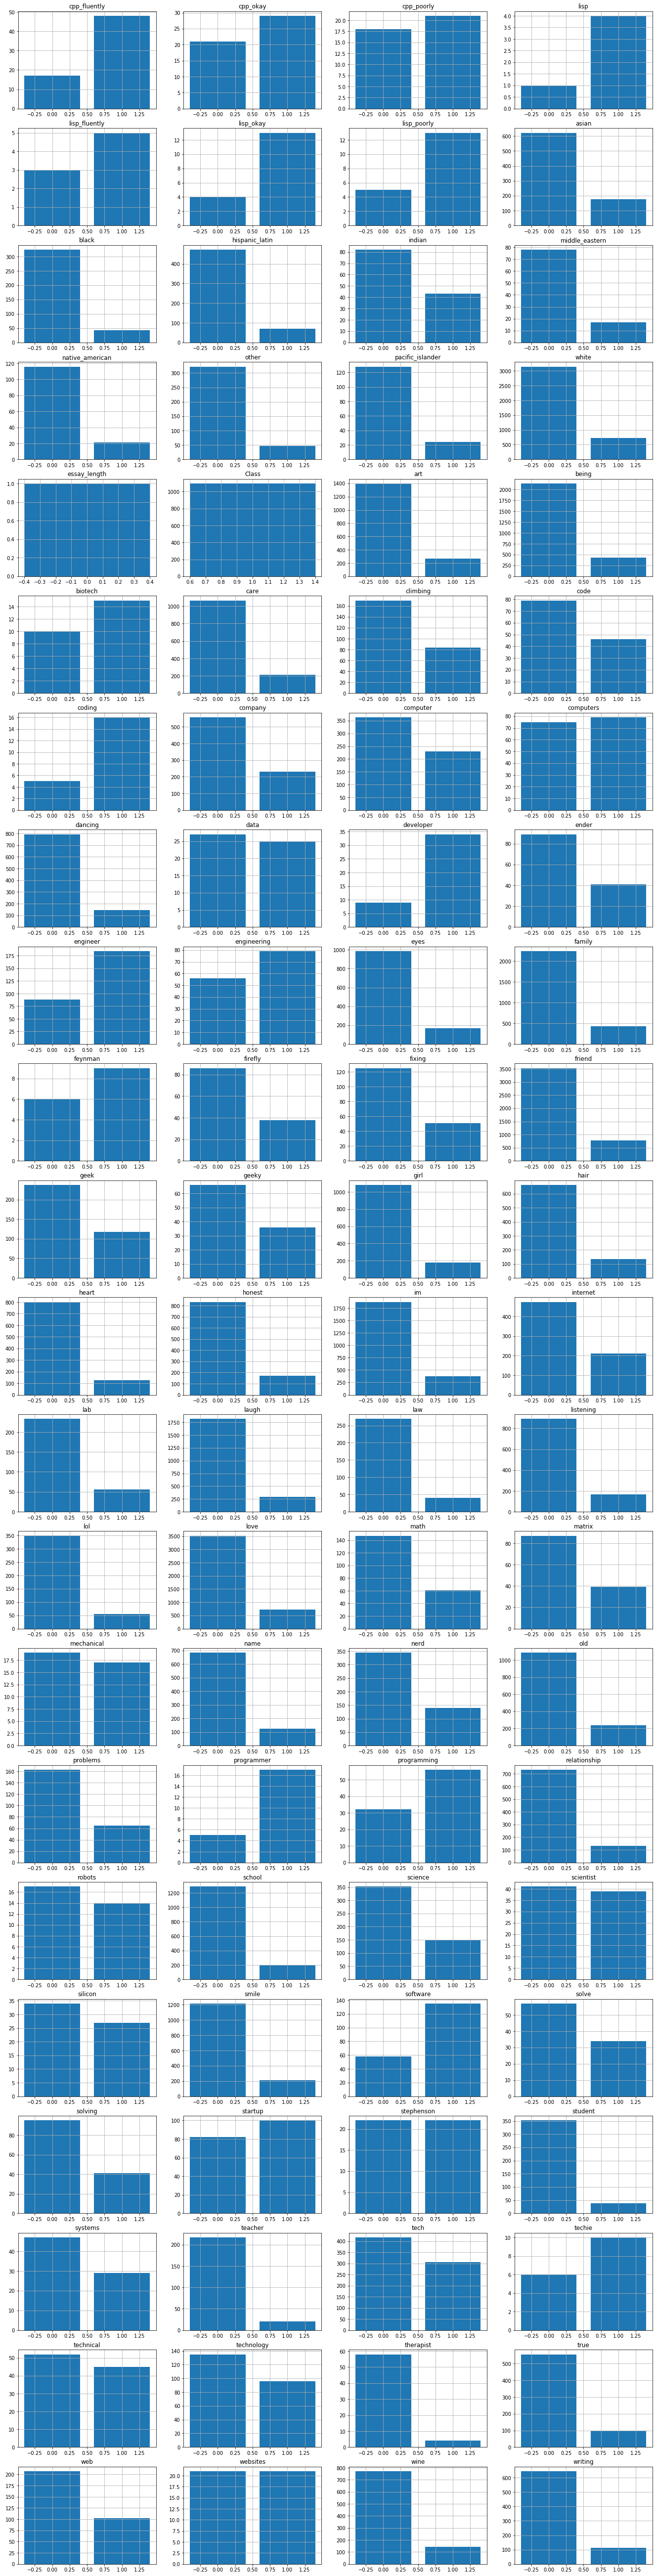

In [136]:
bin_cols = train.columns.values[13:-22]

fig, ax = plt.subplots(22, 4, figsize=(23, 95))

for i in range(22):
    tmp = train.loc[train[bin_cols[i*4]] == 1, 'Class'].value_counts()
    ax[i, 0].bar(tmp.index, tmp)
    ax[i, 0].grid()
    ax[i, 0].set_title(bin_cols[i*4])
    
    tmp = train.loc[train[bin_cols[i*4+1]] == 1, 'Class'].value_counts()
    ax[i, 1].bar(tmp.index, tmp)
    ax[i, 1].grid()
    ax[i, 1].set_title(bin_cols[i*4+1])
    
    tmp = train.loc[train[bin_cols[i*4+2]] == 1, 'Class'].value_counts()
    ax[i, 2].bar(tmp.index, tmp)
    ax[i, 2].grid()
    ax[i, 2].set_title(bin_cols[i*4+2])
    
    tmp = train.loc[train[bin_cols[i*4+3]] == 1, 'Class'].value_counts()
    ax[i, 3].bar(tmp.index, tmp)
    ax[i, 3].grid()
    ax[i, 3].set_title(bin_cols[i*4+3])
    
plt.show()

In [138]:
nerd_col = ['feynman', 'geek', 'geeky', 'engineer', 'engineering', 'developer', 'data', 'computers', 'computer',
           'coding', 'code', 'biotech', 'cpp', 'lisp', 'cpp_poorly', 'lisp_poorly', 'cpp_okay', 'lisp_okay',
            'cpp_fluently', 'cpp_fluently', 'internet', 'math', 'mechanical', 'nerd', 'matrix', 'problems', 
            'programming', 'programmer', 'robots', 'science', 'scientist', 'silicon', 'software', 'solve', 
            'solving', 'startup', 'stephenson', 'systems', 'tech', 'techie', 'technical', 'technology', 'web', 'websites']

nerd = train[nerd_col].copy()
nerd['total'] = nerd.sum(axis=1)
nerd['Class'] = train.Class.values
nerd.head()

,feynman,geek,geeky,engineer,engineering,developer,data,computers,computer,coding,...,stephenson,systems,tech,techie,technical,technology,web,websites,total,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


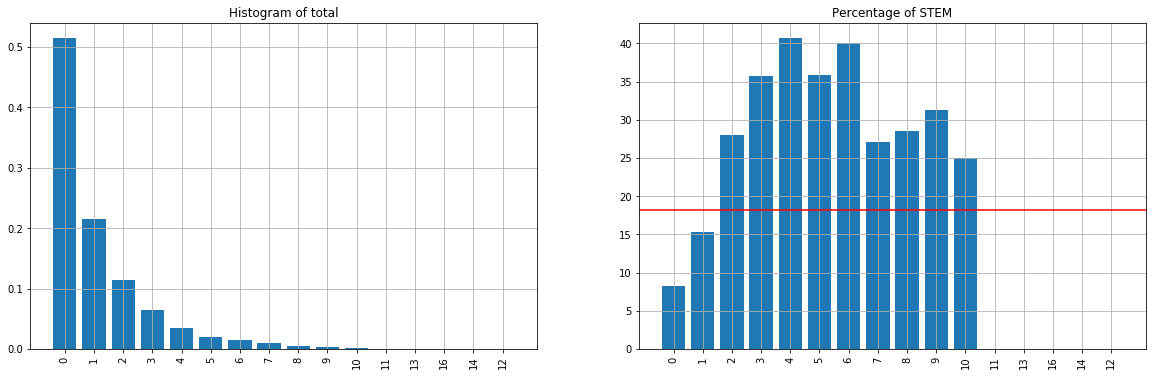

In [139]:
nerd.total = nerd.total.apply(lambda x: str(x))
key, value, cat = plot_info(nerd, 'total', vertical = True , figsize = (20, 6), length=0, rotation=90)

In [141]:
nerd.total = nerd.total.astype(np.int8)
nerd.total[nerd.total > 10] = 0
train['nerdish'] = nerd.total.values

C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:8766: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


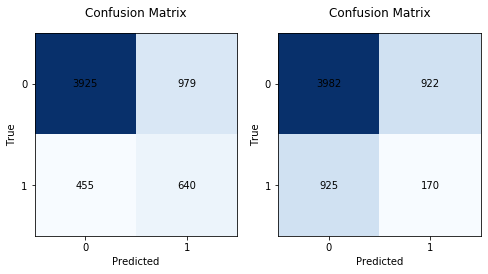

In [144]:
nerd.total = nerd.total.astype(np.int16)
true_pos = nerd[(nerd.total > 1) & (nerd.Class == 1)].shape[0]
true_neg = nerd[(nerd.total <= 1) & (nerd.Class == 0)].shape[0]
false_neg = nerd[(nerd.total <= 1) & (nerd.Class == 1)].shape[0]
false_pos = nerd[(nerd.total > 1) & (nerd.Class == 0)].shape[0]
cf = np.array([[true_neg, false_pos], [false_neg, true_pos]])

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
im = ax[0].matshow(cf, cmap=plt.cm.Blues)
for i in range(cf.shape[0]):
    for j in range(cf.shape[0]):
        ax[0].text(j, i, cf[i, j], horizontalalignment='center', verticalalignment='center')
tick_marks = np.arange(0, 2)

ax[0].xaxis.tick_bottom()
ax[0].set_yticks(tick_marks)
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

y_pred = np.random.rand(train.shape[0])
y_pred[y_pred > 0.8174695782630439] = 1
y_pred[y_pred <= 0.8174695782630439] = 0
true_pos = nerd[(y_pred > 0) & (nerd.Class == 1)].shape[0]
true_neg = nerd[(y_pred == 0) & (nerd.Class == 0)].shape[0]
false_neg = nerd[(y_pred == 0) & (nerd.Class == 1)].shape[0]
false_pos = nerd[(y_pred > 0) & (nerd.Class == 0)].shape[0]
cf = np.array([[true_neg, false_pos], [false_neg, true_pos]])

im = ax[1].matshow(cf, cmap=plt.cm.Blues)
for i in range(cf.shape[0]):
    for j in range(cf.shape[0]):
        ax[1].text(j, i, cf[i, j], horizontalalignment='center', verticalalignment='center')
tick_marks = np.arange(0, 2)
ax[1].xaxis.tick_bottom()
ax[1].set_yticks(tick_marks)
ax[1].set_title('Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.show()

In [148]:
train.to_csv('mat.csv')